# 缩写
- ISN  --  initial sequence number                  初始序列号
- MSS  --  Maximum Segment Size                     最大的分段大小
- MTU  --  Maximum Transmission Unit                最大传输单元
- AIMD --  "Additive Increase Multiplicative Decrease"  加法增加乘法减少


# Transport-layer services
- 传输层通常在操作系统内核内执行
- 发送者：将应用信息分解成片段，传递给网络层
- 接收者：将片段重新组合成信息，传递给应用层

# UDP(User Datagram Protocol): connectionless transport
  - "尽力而为 "的服务，发送并希望得到最好的结果
  - 优点
    - 可以在网络服务受到影响时发挥作用
    - no handshaking， （不产生RTT）
  - 缺点
    - 段落可能丢失，不按顺序传送
    - no delay guarantees
    - no bandwidth guarantees
    - no congestion control
    
  - 每个UDP段的处理独立于其他段
  - Applications that use UDP:
    - streaming multimedia apps (loss tolerant, rate sensitive)
    - DNS
    - SNMP
    - HTTP/3
    - 语音/视频聊天
    - 游戏（尤其是FPS）
  - 如果需要通过UDP进行可靠的传输（例如HTTP/3）
    - 可以在应用层增加所需的可靠性
    - 可以在应用层增加拥塞控制

# TCP(Transmission Control Protocol): connection-oriented reliable transport
  - reliable, in-order delivery
  - congestion control
  - flow control
  - checksum
  

# Multiplexing and demultiplexing
- 复用、解复用：基于段、数据报头字段的值
- 多路复用/解复用发生在所有层

- multiplexing at sender:
  - 处理来自多个套接字的数据，添加传输头（后来用于解复用）

- demultiplexing at receiver:
  - 使用头信息将收到的片段传递给正确的套接字

# Connectionless transport: UDP
- 当创建数据报以发送至UDP套接字时，必须指定
  - 目的地 IP 地址
  - 目的地端口
- 仅使用目的地IP和端口号进行解复用
- 具有相同目的端口的IP/UDP datagrams，但不同的源IP地址和/或源端口号将被引导到接收主机的同一个套接字
- 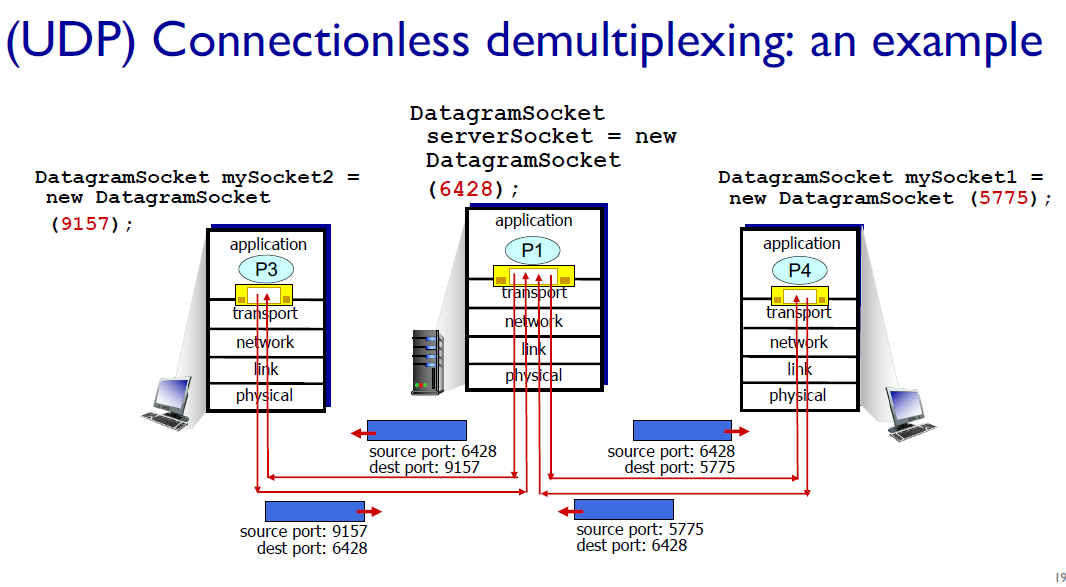


# Connection-oriented transport: TCP
- TCP套接字通过以下方式识别
- 4元组
  - 源IP地址
  - 源端口号
  - 目的地IP地址
  - 目的地端口号
- 服务器可以支持许多同步的TCP套接字。
  - 每个套接字由它自己的4元组识别
  - 每个套接字都与一个不同的连接客户端
- 解复用：接收方使用所有四个值（4元组）来引导分段到适当的套接字
- 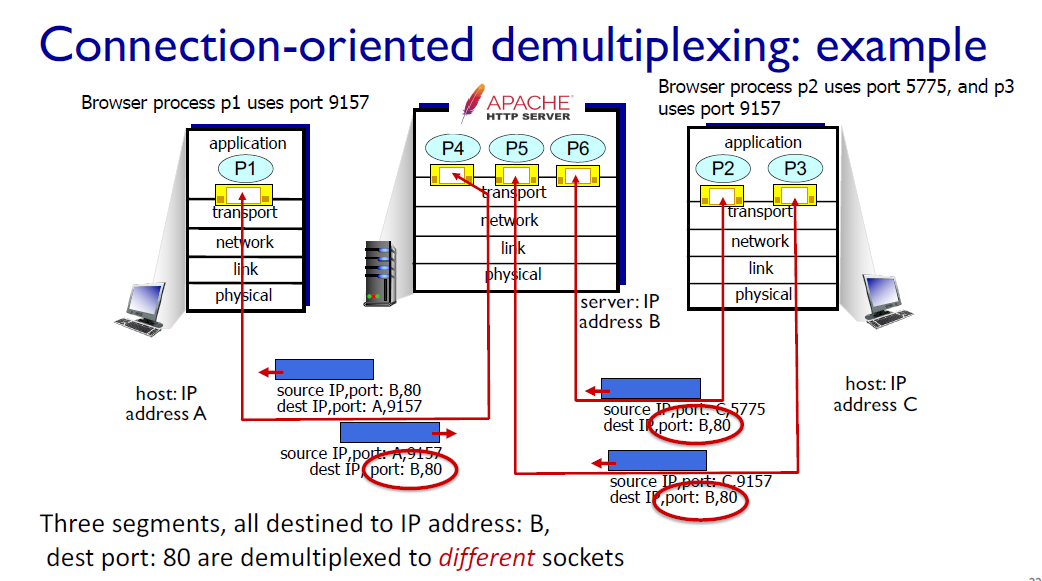

- TCP Maximum Segment Size
  - IP packet
    - 不大于link layer 的 Maximum Transmission Unit（MTU）
    - 例如，在以太网中最多为1500字节
  - TCP packet
    - IP包内有一个TCP头和数据
    - TCP头 >= 20字节
  - TCP segment
    - 不超过Maximum Segment Size（MSS）字节数
    - 例如，最多连续1460个字节的数据流
    - MSS = MTU-20（最小IP头）-20（最小TCP头）

- Use random ISN
  - Avoids ambiguity with back-to-back connections between same end-points
  - Potential security issue if the ISN is known

- ACKing and Sequence Numbers
  - 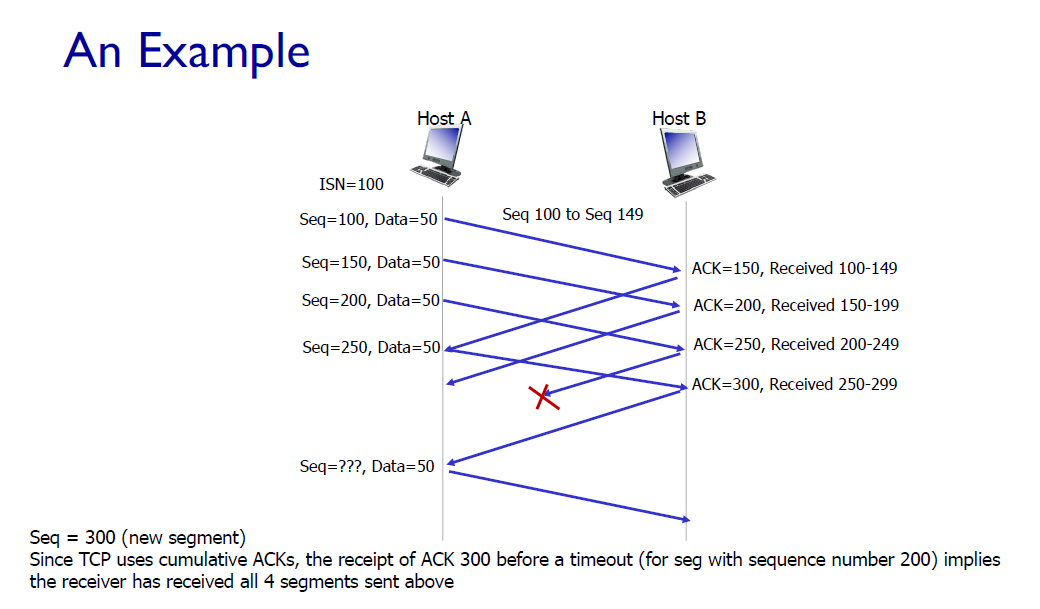
  - 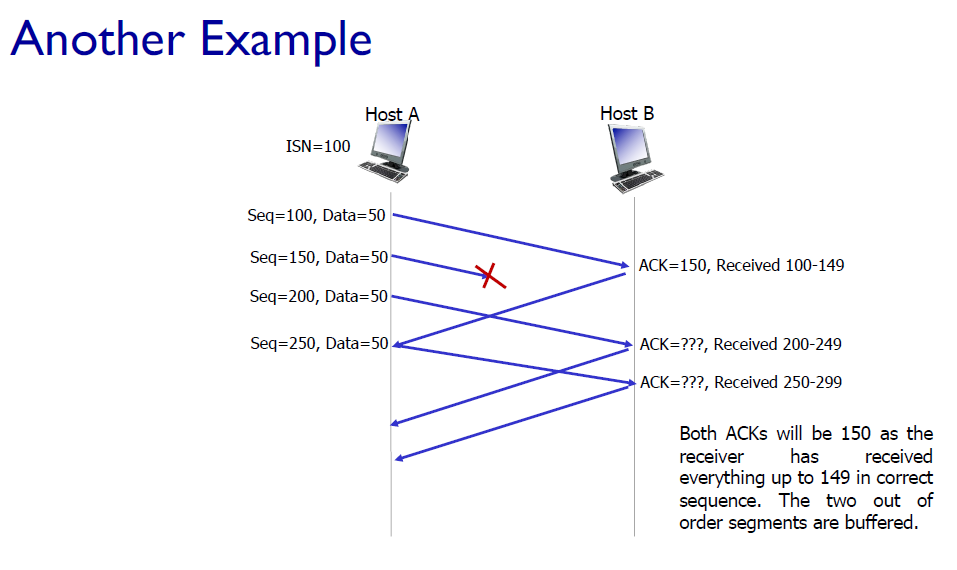
  - Piggybacking 搭便车
    - 通常情况下，连接的双方都会发送一些数据，比如：接收方同时回复和ack
    - 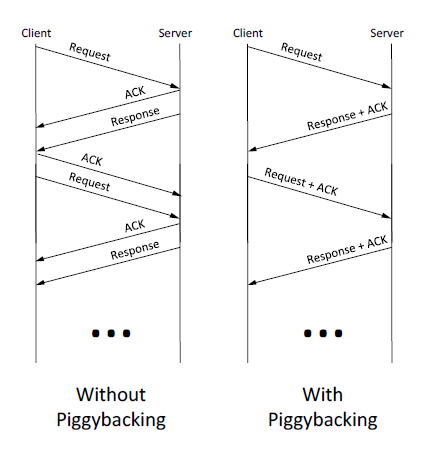
    - 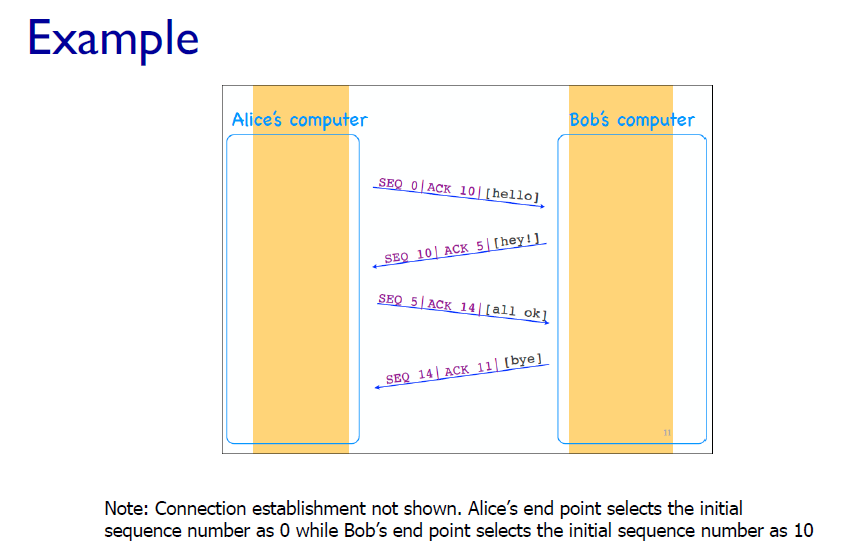
    - 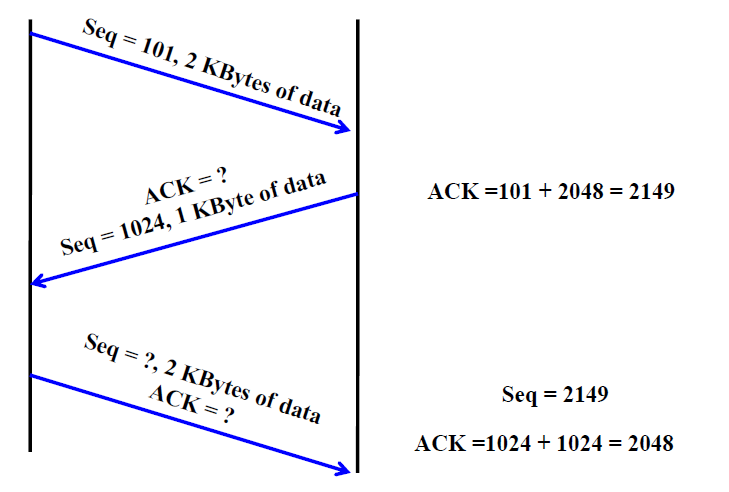

- how to set TCP timeout
  - `TimeoutInterval = EstimatedRTT + 4*DevRTT`
  -` DevRTT = (1-b)*DevRTT + b*|SampleRTT-EstimatedRTT|`
    - typically, `b = 0.25`
    - `SampleRTT`：
      - 测量从网段传输到收到ACK的时间
      - 忽略重传
      - 最近几次测量的平均值（更平滑），而不仅仅是当前的SampleRTT
  - 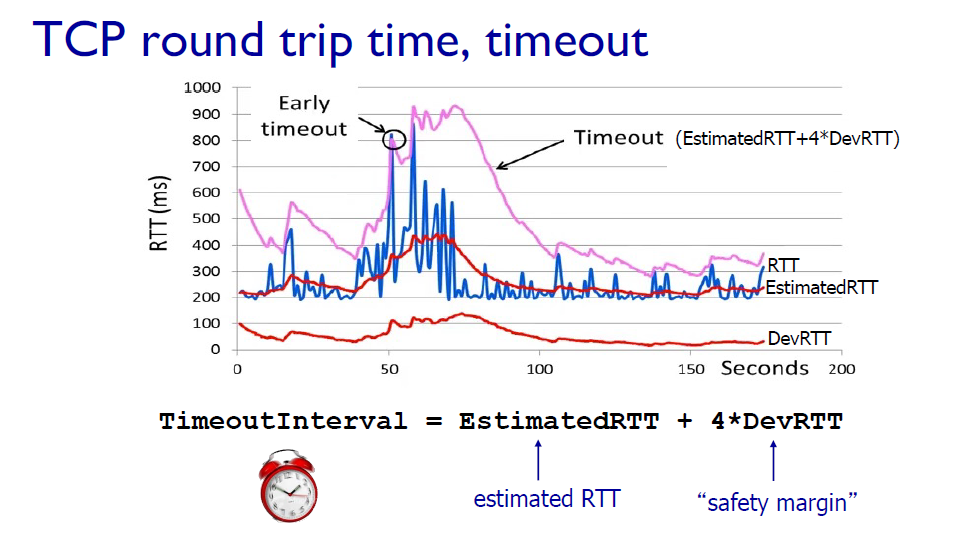


In [91]:
# 计算超时间隔
EstimatedRTT = 100        # ms
DevRTT = 9                # ms
New_SampleRTT = 108       # ms
a = 0.125
b = 0.25

DevRTT = (1 - b) * DevRTT + b * abs(New_SampleRTT - EstimatedRTT)
EstimatedRTT = (1 - a) * EstimatedRTT + a * New_SampleRTT

TimeoutInterval = EstimatedRTT + 4 * DevRTT
print(TimeoutInterval, 'ms')



136.0 ms


In [89]:
# 求造成超时间隔不变的DevRTT
from sympy.solvers import solve
from sympy import Symbol

EstimatedRTT = 100        # ms
New_SampleRTT = 108       # ms
a = 0.125
b = 0.25
DevRTT = Symbol('DevRTT')

NewDevRTT = (1 - b) * DevRTT + b * abs(New_SampleRTT - EstimatedRTT)
NewEstimatedRTT = (1 - a) * EstimatedRTT + a * New_SampleRTT

f = EstimatedRTT + 4*DevRTT - NewEstimatedRTT - 4*NewDevRTT

result = solve(f, DevRTT)
print(result)


[9.00000000000000]


# TCP: retransmission scenarios
  - 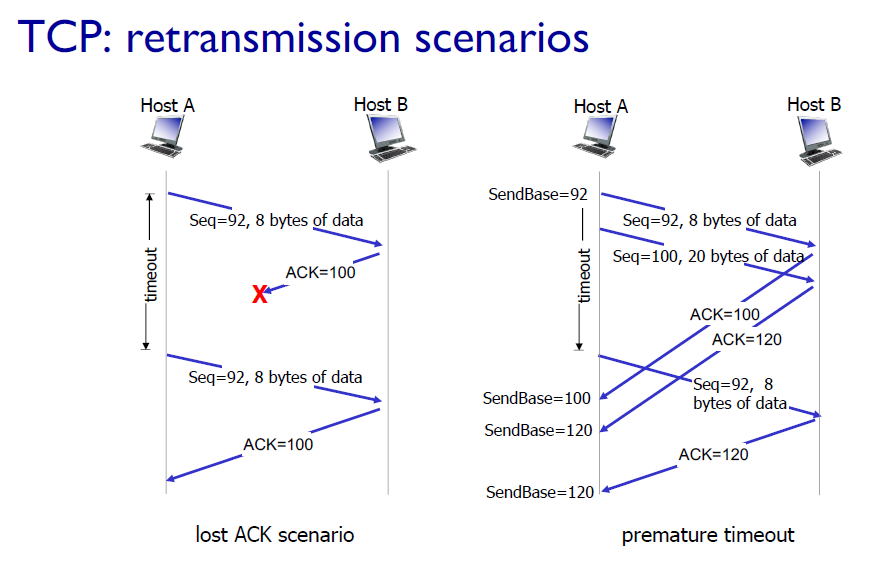
  - 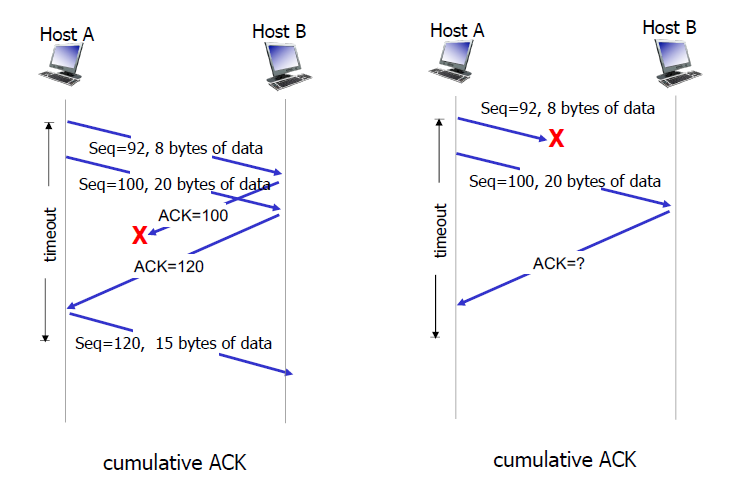

# fast retransmit
  - 使用重复的ACK来触发早期重传的优化方法
  - 如果发送方收到3个相同数据的额外ACK，则以最小的序列重新发送未ACK的段
    - 可能是unACKed的段丢失了，所以不需要等待超时。
  - 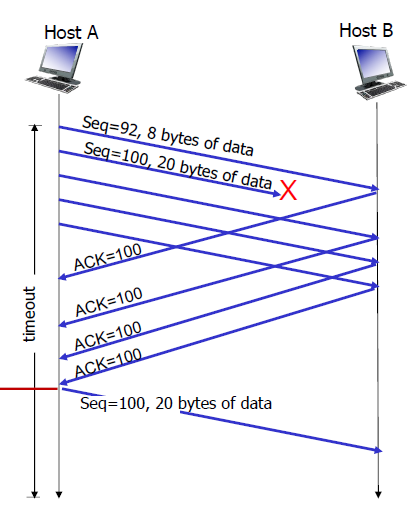

# TCP flow control
  - 为了应对如果网络层传递数据的速度比应用层从TCP Socket Receiver buffers移除数据的速度快的情况
  - 接收者控制着发送者，所以发送者不会因为传输过多、过快而溢出接收者的缓冲区
  - TCP接收方在TCP头的rwnd(receive window)字段中 "公布 "空闲的缓冲区空间
    - 通过套接字选项设置RcvBuffer大小（典型的默认值是4096字节）
    - 许多操作系统自动调整RcvBuffer
  - 发送方限制unACKed（"飞行中"）的数据量，以接收rwnd为限
  - 保证接收缓冲区不会溢出

  - 如果rwnd=0怎么办？
    - 发送者将停止发送数据
    - 最终，当应用程序读取一些字节时，接收缓冲区会有空间
  - 发送方不断向接收方发送带有one data byte的TCP段
  - 这些段被丢弃，但被接收方以零窗口大小确认。
  - 最终当缓冲区清空时，非零窗口被公布出来

# TCP connection management
- TCP连接管理在交换数据之前，发送方/接收方 "握手"。
  - 同意建立连接（各自知道对方愿意建立连接）
  - 同意连接参数（例如，开始序列号）

- TCP 2-way handshake
  - 可变延迟
  - 因信息丢失而重传的信息（如req_conn(x)）
  - 消息重新排序
  - 无法 "看到 "另一方
  - 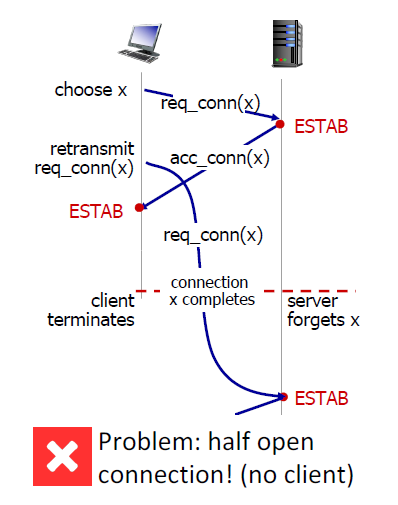

- TCP 3-way handshake
  - 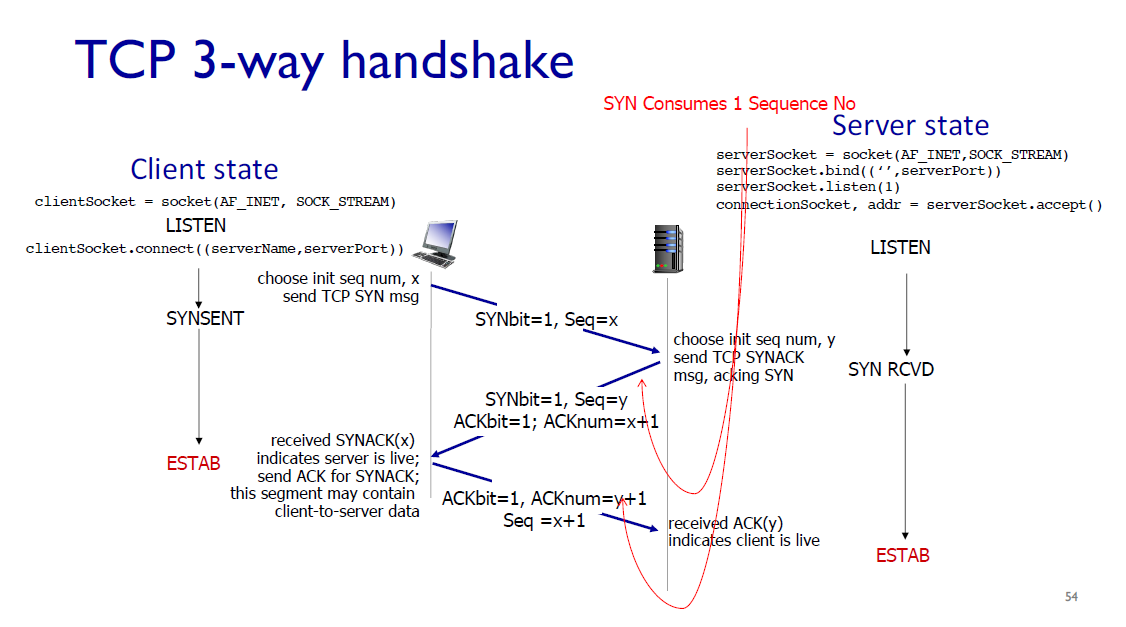
  
  - `SYN`
    - Consumes 1 seq num
    - choose init seq num x send TCP SYN msg
    - 如果SYN数据包丢失怎么办
      - 发送方设置一个定时器，等待SYN-ACK的到来,必要时重发SYN
      - SHOULD (RFCs 1122,2988) use default of 3 second,
      - RFC 6298 use default of 1 second
  
  - `FIN`
    - Consumes 1 seq num
    - 客户端、服务器各自关闭自己一方的连接
    - 发送TCP段，FIN位=1
    - 用 ACK 响应收到的 FIN
    - 在收到 FIN 时，ACK 可以与自己的 FIN 结合起来
    - 可以处理同时进行的FIN交换
    - 如果发送FIN后没有收到ack，假设连接已关闭，什么也不做
    - 正常终止，一次一个 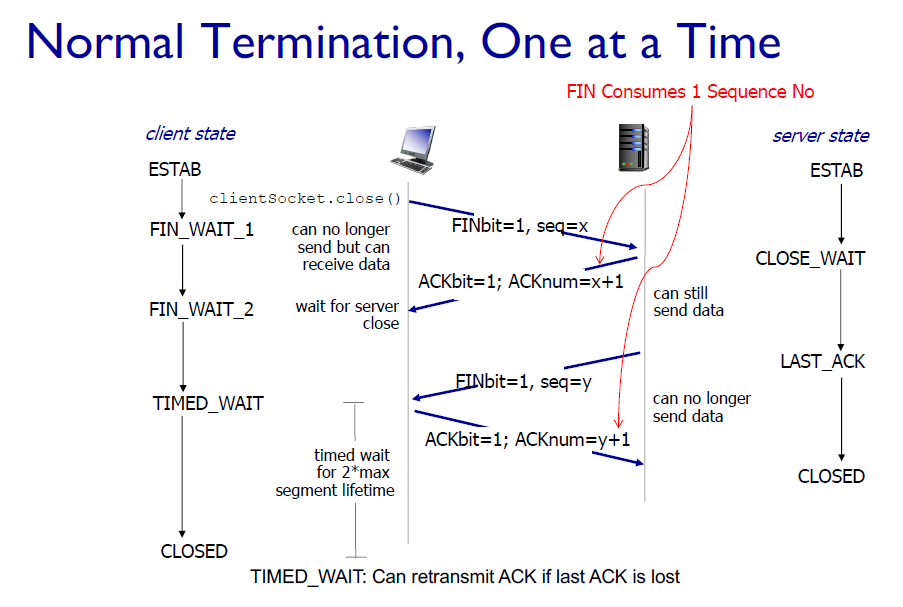
    - 两者一起 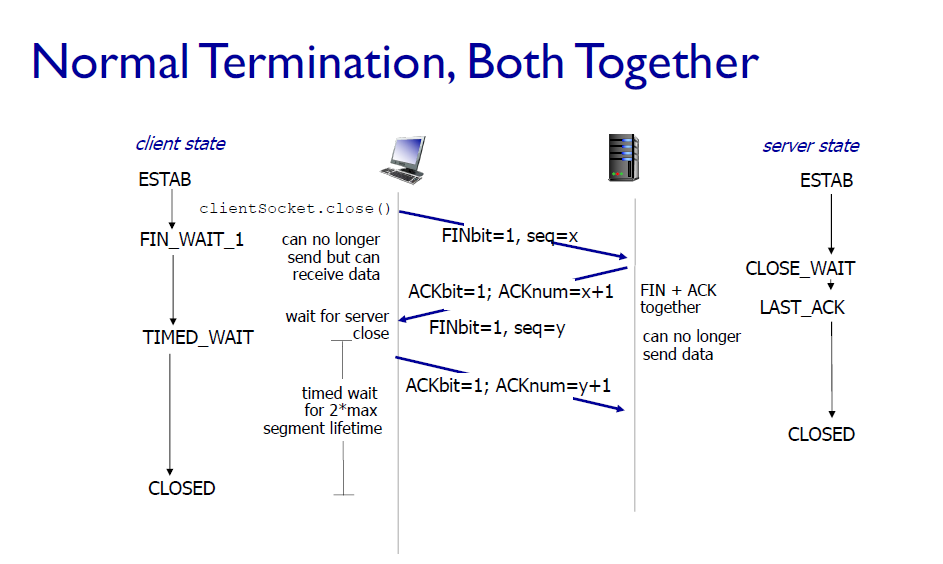
    - 同时关闭 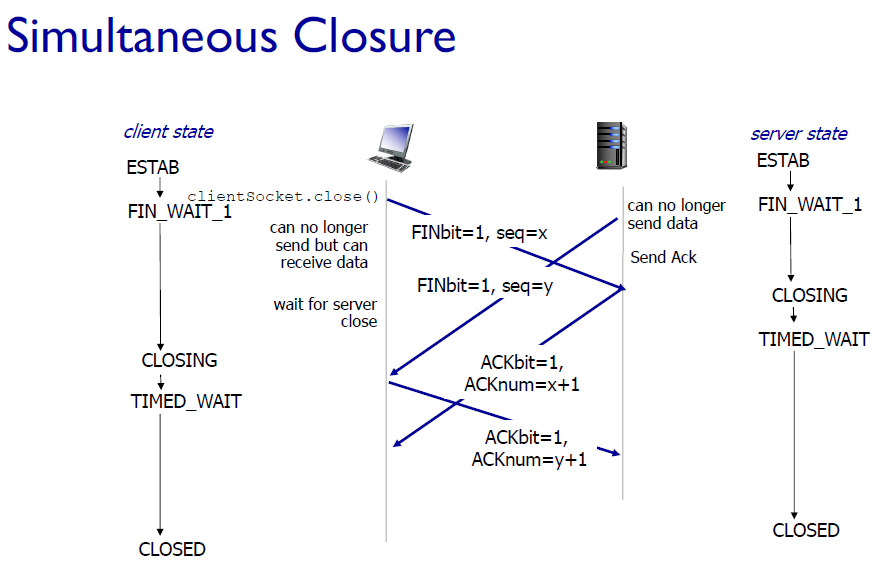

  - `RST`
    - A向B发送了一个RESET（RST）
      - 例如，因为A上的应用进程崩溃了
    - 然后如果B没有接受RST（也可能loss）
      - B再发送任何东西，将引起A发送另一个RST

# TCP SYN攻击（SYN flooding）
- 歹徒创建一个假的SYN数据包
  - 目的地是受害者主机的IP地址（通常是一些服务器）
  - 源是一些欺骗性的IP地址
  - 受害主机收到后，创建一个TCP连接状态，即分配缓冲区。创建变量等，并向被欺骗的地址发送`SYN ACK`（半开放连接）
  - `ACK`永远不会回来
  - 在超时后，连接状态被释放
  - 然而在这个时间段内，连接状态是不必要的
  - 进一步的黑客会发送大量的假`SYN`， 可以很容易地压倒受害者
- 解决方案:
  - 增加连接队列的大小
  - 减少三向握手的超时等待
  - 防火墙：已知的坏源IP地址列表
  - TCP SYN Cookies

# TCP SYN Cookie
- 收到`SYN`后，服务器不创建连接状态
- 它创建一个初始序列号（init_seq），该序列号是SYN数据包的源和目的IP地址及端口号的哈希值,包括一个 secret key
  - 用包含`init_seq`的`SYN ACK`进行回复
  - 服务器不需要存储这个序列号
- 如果原始`SYN`是真实的，将返回一个`ACK`
  - 在相同的头字段上运行相同的哈希函数以获得`init_seq`
  - 检查ACK是否等于`（init_seq+1）`
  - 仅在上述情况下创建连接状态
- 如果是假的`SYN`，由于没有创建状态，所以不会造成任何伤害
- https://etherealmind.com/tcp-syn-cookies-ddos-defence/


In [165]:
# Calculate the checksums (8 bits)
from functools import reduce

def overflowAdd(a, b):
    return ((a+b)&0xff) + 1 if (a+b)>>8 == 1 else (a+b)

myBits = ['01010101', '01110000', '01001100']
res = reduce(overflowAdd, map(lambda x: int(x,2), myBits))
print('1s complement: {0:08b}'.format(~res & 0xff))
print('2s complement: {0:08b}'.format(-res & 0xff))

# Fancy way to do it
# print('1s complement: {0:08b}'.format(~reduce(lambda a, b: ((a+b)&0xff) + 1 if (a+b)>>8 == 1 else (a+b), map(lambda x: int(x,2), ['01010101', '01110000', '01001100'])) & 0xff))
# print('2s complement: {0:08b}'.format(-reduce(lambda a, b: ((a+b)&0xff) + 1 if (a+b)>>8 == 1 else (a+b), map(lambda x: int(x,2), ['01010101', '01110000', '01001100'])) & 0xff))


1s complement: 11101101
2s complement: 11101110


# Reliable data transfer protocol (rdt)

- **rdt1.0**
  - 假设底层通道完全可靠
    - 没有比特错误
    - 没有数据包的丢失
  - Nothing to do
  - 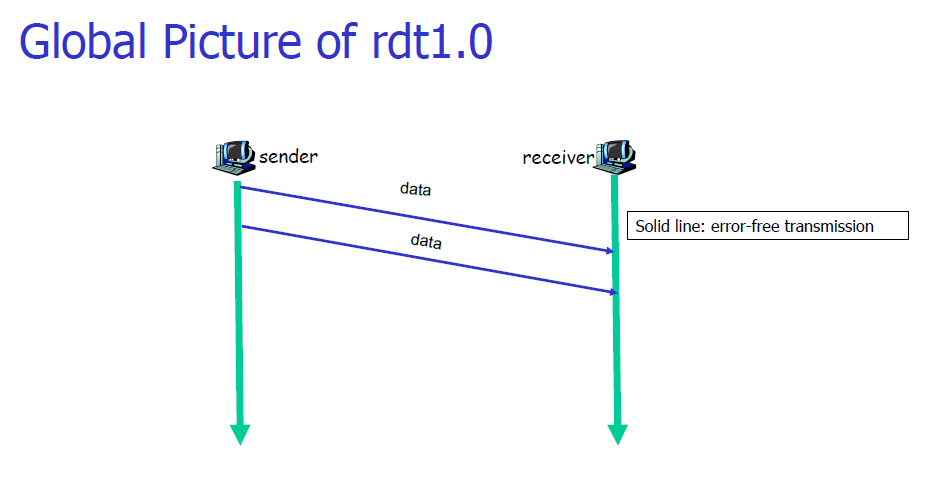

- **rdt2.0** channel with bit errors
  - 假设底层通道可能会翻转数据包中的位
    - 用checksum来检测比特错误
  - `acknowledgements(ACKs)`：接收方明确告诉发送方，收到了包。
  - `negative acknowledgements（NAK）`：接收方明确告诉发送方，包有错误。
  - 发送方在收到NAK后重新发送包。
  - rdt2.0中的新机制（超越rdt1.0）
    - 错误检测
    - feedback:控制信息（ACK,NAK）从接收方到发送方
    - 重传
  - Stop and Wait Protocol 
    - 发送方发送一个数据包，然后等待接收方的响应
  - 致命缺陷：
    - 如果ACK/NAK损坏，发送方不知道
    - 发送方只能重发
  - 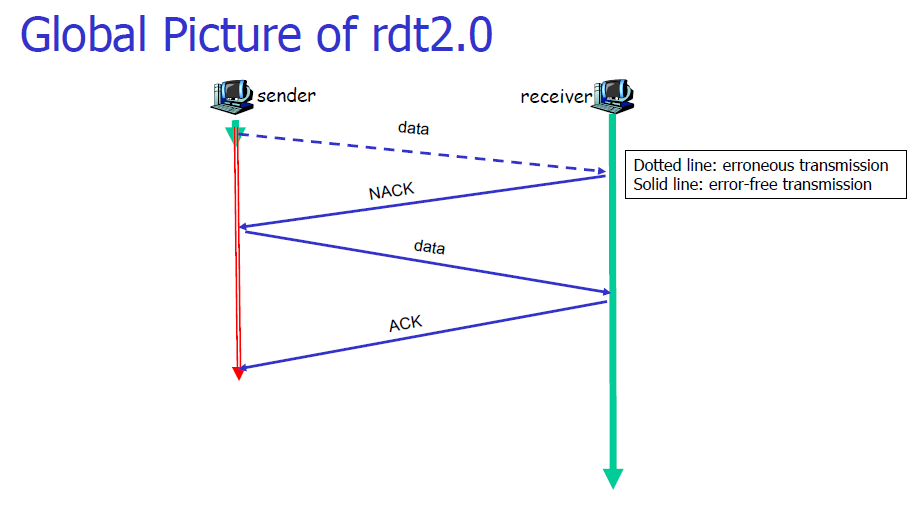

- **rdt2.1**
  - 新措施
    - 每个包都有sequence number
    - Checksum for ACK/NACK
    - Duplicate detection， 接收者丢弃重复的数据包
  - 发件人：
    - 两个seq num (0,1)
    - 必须检查收到的 ACK/NAK 是否被破坏
    - 必须记住预期的包应该有0还是1的序列
  - 接收者：
    - 必须检查收到的数据包是否是重复的
    - 状态指示 0 或 1 是预期的 pkt seq
    - 注意：接收方不能知道它的最后一个ACK/NAK是否被发送方收到
  - 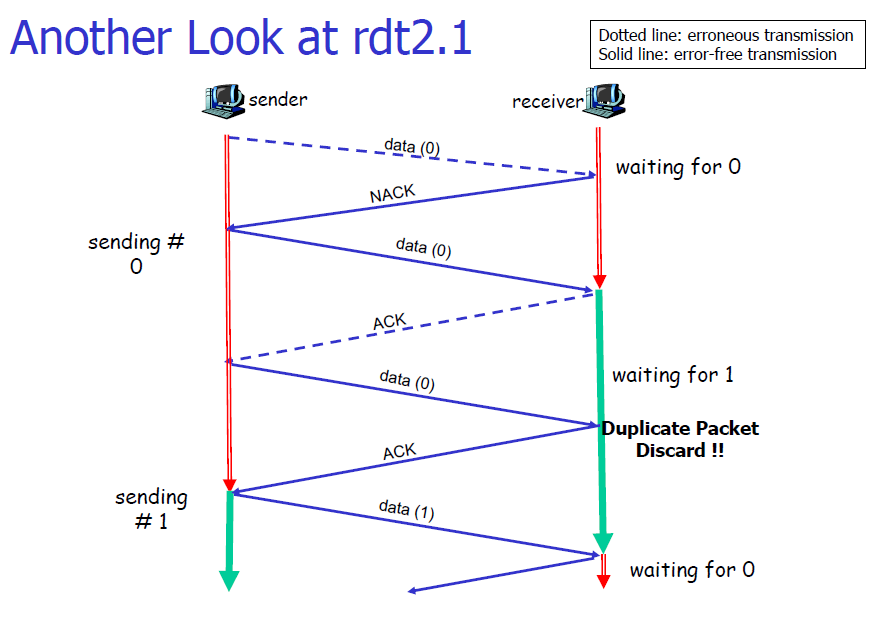

- **rdt2.2** a NAK-free protocol
  - 与rdt2.1功能相同，不过只使用ACKs
  - 替换NAK，接收方为最后收到的包发送ACK。
    - 接收方必须明确被ACK的包的seq
  - 如果发送方收到重复seq的ACK，结果和收到NAK相同，重发当前数据
  - 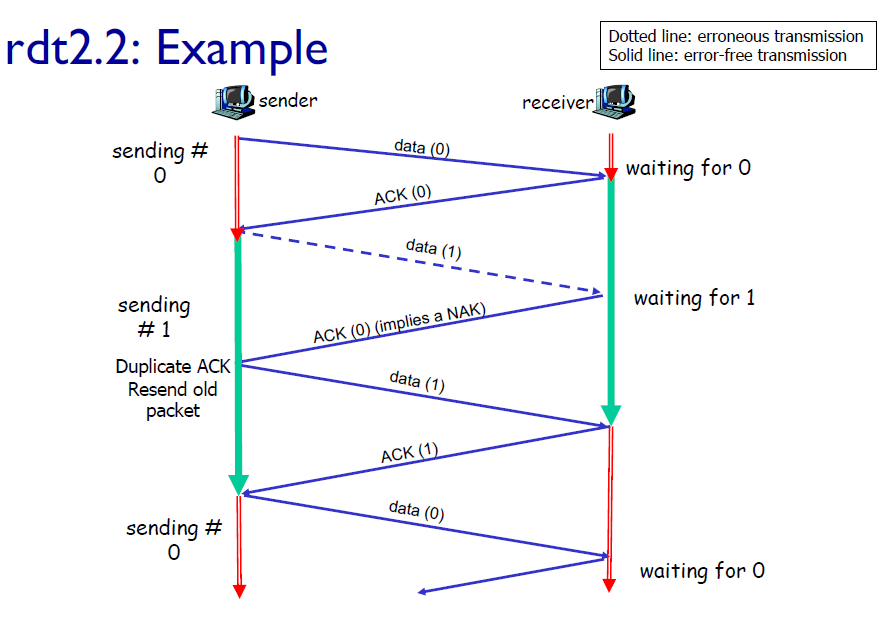

- **rdt3.0** channels with errors and loss
  - New channel assumption：底层信道也会丢失数据和ACKs
  - 解决方法：
    - 发送方在合理时间内等待ACK，计时器超时就重发
    - 如果在这段时间内没有收到ACK，则进行重传
    - 如果 pkt 或 ACK 只是延迟了没有丢失，此时重传将是重复的，但seqs已经处理了这个问题!，接收方直接丢弃即可
    - 发送方对重复的ACK不进行重传
  - 基础rdt 3.0协议的性能非常差!
    - 协议限制了底层基础设施（通道）的性能
  - 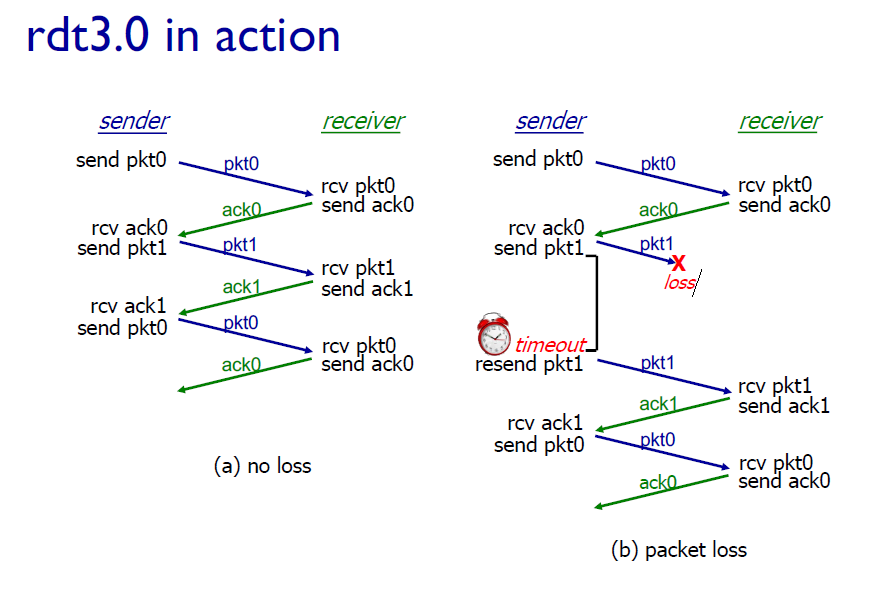
  - 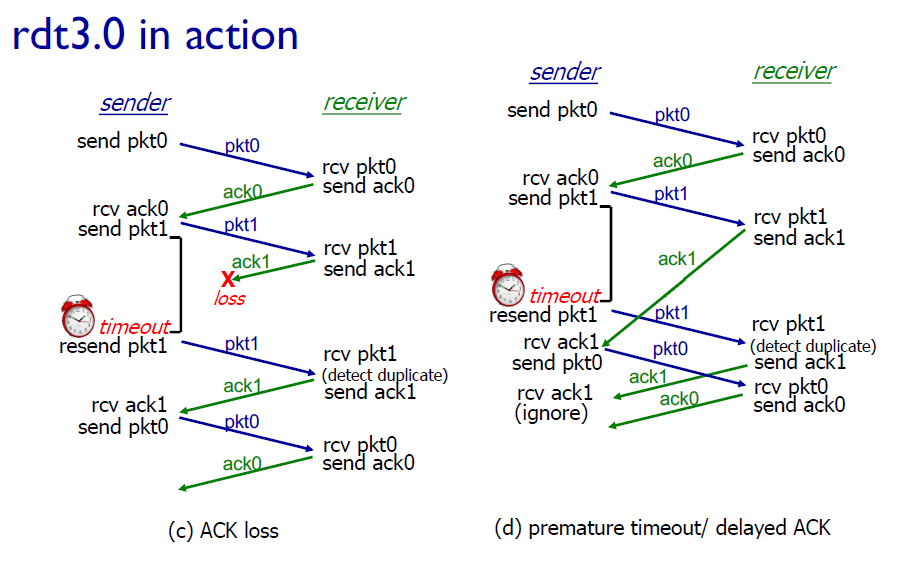

- **rdt3.0 with pipelined protocols operation** 流水线协议操作
  - 管道化：发送方允许多个 "飞行中 "的、尚未被确认的数据包
    - 必须增加序列号的范围
    - 在发送方和/或接收方进行缓冲
    - Go Back N, Selective Repeat

In [3]:
# Performance of rdt3.0 (stop-and-wait)

link = 10**9        # bits/sec  1 Gbps link
prop_delay = 15     # ms
packet_size = 8000  # bits

trans_delay = packet_size / link    # sec
print("time to transmit packet into channel:")
print(f'\tTransmission delay: {trans_delay*10**6} microsecs')
print(f"\tSender Utilization: 发送者忙于发送的时间的百分比 = {round((trans_delay*10**3)/(prop_delay*2+trans_delay*10**3), 5)}")

time to transmit packet into channel:
	Transmission delay: 8.0 microsecs
	Sender Utilization: 发送者忙于发送的时间的百分比 = 0.00027


# Go Back N
- 发件人:"窗口"，最多可以有N个连续传输但未ACK的pkts
  - k-bit seq in pkt header
- `cumulative ACK`：ACK(n)。ACK(n)：对所有数据包进行ACK，包括序列号
  - 收到ACK(n)时：将窗口继续移动，从n+1开始
- 对*最早的*飞行数据包记录定时器
- 超时(n)：重发数据包n和窗口中所有更早序列号的数据包
- ACK-only: 始终为迄今为止正确接收的，顺序最高的序列号的数据包发送ACK
  - 可能会产生重复的ACK
  - 只需要记住`rcv_base` （最早的在途中的数据包序号）
- 在收到失序的数据包时：
  - 可以丢弃（不缓冲）或缓冲：由具体实现决定
  - 用最高的顺序的序列号重新发送ACK数据包
- 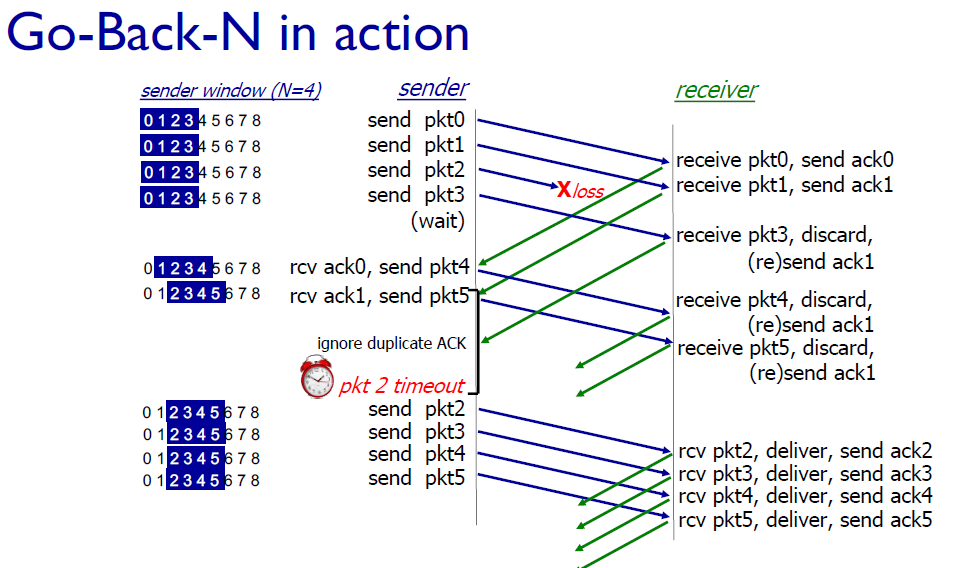


# Selective Repeat
- 接收者单独确认所有正确收到的数据包
  - 根据需要对数据包进行缓冲，以便最终按顺序传递给上层
- 发送方对未ACK的数据包**单独**进行超时/重发处理
  - 发送方为每个未回信的数据包保留定时器
- 发送方窗口
  - N个连续的序列
  - 限制已发送的、未回复的特定数据包（序号）
- 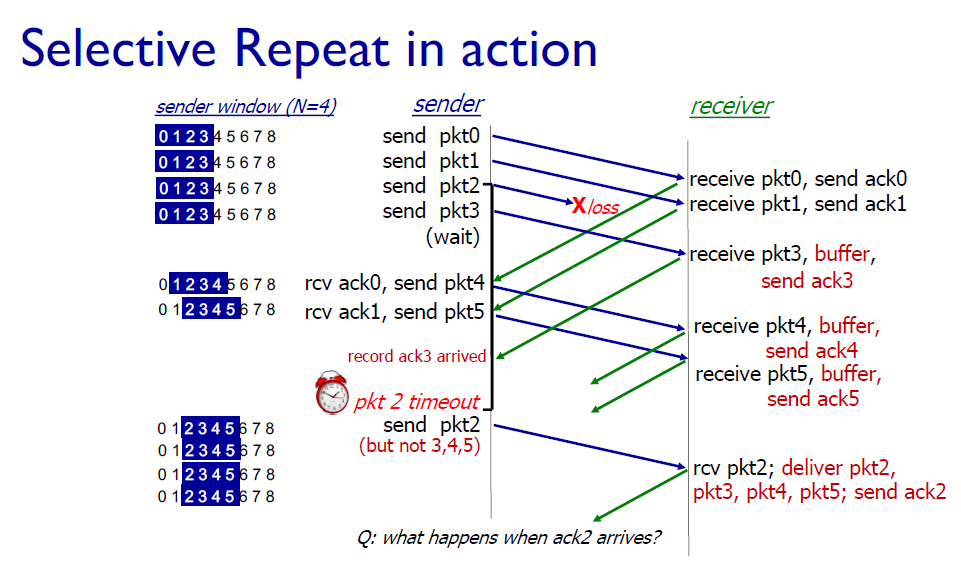
- 漏洞：
  - 当选择特定的窗口大小和序号范围时，也许会发生 接收方返回实际未收到包的ack
- 解决方案：
  - Sender window size <= 1/2 of Sequence number space

# Principles of congestion control
- "太多来源发送太多数据，速度太快，网络无法处理" 与流量控制不同!
- 通常在 routers 发生
- 表现形式:
   - 丢失数据包（路由器的缓冲区溢出）
   - 长时间的延迟（路由器缓冲区的排队）
   - 最终导致反复大量的重传，恶性循环
   - Knee and Cliff 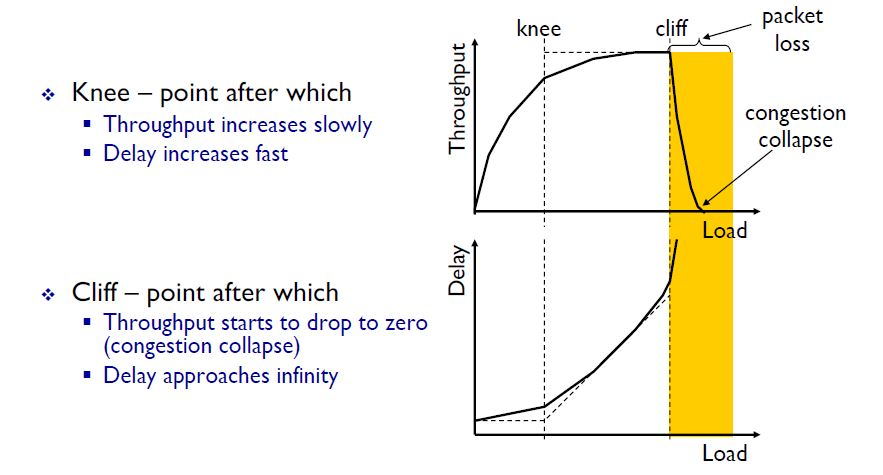

# TCP congestion control
- TCP改变窗口大小以控制发送率
- TCP发送速率：
  - 大概是：发送cwnd字节，等待RTT的ACK，然后发送更多字节
  - rate = cwnd/RTT (bytes/sec)

- Congestion Window: `CWND`
  - 在不溢出路由器的情况下可以发送多少个字节
  - 由发送方使用拥塞控制算法计算出来的
  - 本讲座将讨论以MSS为单位的CWND问题, 真正的实现是以字节为单位维持CWND的
  - **Detection Congestion: Infer Loss**
    - 重复的ACKs：孤立的损失
      - 重复ACK表明网络能够传送一些片段
    - 超时：更严重
      - 没有足够的双份ACKs
      - 必须遭受几次损失
    - 收到ACK（新数据）时：增加速率, 检测到丢失时：降低速率
    
    - **slow start threshold” (ssthresh)** 慢速启动阈值
      - 初始化为一个大值
      - 当cwnd = ssthresh时 送方从`slow start` 到 `AIMD`
      - 丢失时，ssthresh = CWND/2
    
    - **TCP Slow Start** (Bandwidth discovery)
      - 当连接开始时，以指数形式增加速率，直到第一个损失事件
      - 最初`cwnd = 1 MSS`
      - 每收到一个RTT（所有的ACK）就双倍cwnd
      - 或者更简单的实现是，每收到一个ACK就递增cwnd
        - 每个ACK的`cwnd += 1`
    
    - **(AIMD) Additive Increase Multiplicative Decrease** 加法增加乘法减少
      - `Repeated probing`（速率增加）和`back-off`（速率减少）, 被称为`Congestion Avoidance`（CA）
      - 加法增加：每个RTT, `cwnd + 1 MSS`，直到检测到丢失为止
        - 简单实现：对于每个成功的ACK，`cwnd = cwnd + 1/cwnd` (因为一个窗口中有cwnd/MSS数据包)
      - 乘法递减：丢失后将cwnd减半

    - **总结** TCP-Reno
      - Init
        - CWND（初始化为一个小常数）MSS的倍数
        - ssthresh (初始化为一个大常数)
        - 还有dupACKcount和定时器，和以前一样
      
      - Event
        - [ACK]（新数据）
          - `If CWND < ssthresh (SS phase)`  
            - 每个ack `CWND += 1`  
            - 也就是一个RTT后 `CWND = 2xCWND`
          - `Else (CA phase)`                
            - 每个ack`CWND = CWND + 1/CWND`  
            - 也就是一个RTT后 `CWND = CWND + 1`

        - [dupACK] (旧数据的重复ACK)
          - `dupACKcount ++`
          - `If dupACKcount = 3`  fast retransmit 
            - `ssthresh = CWND/2`
            - `CWND = CWND/2`
        
        - [TimeOut]
          - `ssthresh = CWND/2`
          - `CWND = 1`


- Flow control window: `Advertised / Receive Window (RWND)`
  - 在不溢出接收方缓冲区的情况下可以发送多少个字节
  - 由接收方决定并报告给发送方

- Sender-side window = `minimum{CWND, RWND}`


In [2]:
# 计算窗口大小必须是多大才能使信道利用率大于某值

prop_delay = 15     # ms
rtt = (prop_delay*2)*(10**-3)    # sec
packets_len = 1500  # bytes
trans_link = 10**9  # bits/sec  1 Gbps link
channel_U = 0.98    # channel utilization 98%


x = ((packets_len*8)/trans_link) / (rtt+(packets_len*8)/trans_link)
print(f'{channel_U/x} packets')


2450.98 packets


# TCP 序列号例题
- 两个主机A和B建立TCP连接。主机A在一个TCP段中向主机B传输200字节的数据，该TCP段被B成功接收并确认，然后主机B在一个单段中向主机A传输1000字节的数据，A确认。然后，主机B通过发出一个由主机a承认的FIN来关闭连接。主机a现在发出一个由主机B承认的FIN段。假设主机a和B使用的初始序列号(ISN)是33000和55000，那么a和B在他们最后的ACK中向另一端的FIN段发送响应时使用的序列号是什么?

|Segment No| Type |S to R| SeqNo | AckNo |
|  ---- |  ----  | ----  | ----  | ----  |
|1      |SYN     |A->B   | 33000 | NA    |
|2      |SYN/ACK |B->A   | 55000 | 33001 |
|3      |ACK/DATA|A->B   | 33001 | 55001 |
|4      |ACK/DATA|B->A   | 55001 | 33201 |
|5      |ACK     |A->B   | 33201 | 56001 |
|6      |FIN     |B->A   | 56001 | 33201 |
|7      |ACK/FIN |A->B   | 33201 | 56002 |
|8      |ACK     |B->A   | 56002 | 33202 |
